## 任务编排(Orchestrator-Worker)

Orchestrator负责将复杂的任务分解为多个子任务，并分配给Worker执行,Worker负责执行具体的任务，最终再由合成器(Synthesizer)将Worker的结果合并成最终结果。

任务编排与并行化在拓扑结构上类似，但是他们有个关键性的区别：灵活性————任务编排的子任务不是预先定义好的，而是有编排器根据具体的输入动态生成的。

<img src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png" alt="并行化" width="600"/>






In [1]:
from dotenv import load_dotenv
import os
from langchain_anthropic import ChatAnthropic

load_dotenv()
llm = ChatAnthropic(model="claude-3-5-sonnet-latest",
        base_url="https://aihubmix.com",
        api_key=os.getenv("ANTHROPIC_API_KEY"))

In [3]:
from typing import Annotated, List
import operator
from pydantic import BaseModel, Field


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

## 如何动态创建节点
前面我们接触的工作流中的节点都是预先定义好的，但是编排模式却是在运行的过程中动态创建的。这种方式也很常见，所以langgraph提供了Send API来支持此功能。

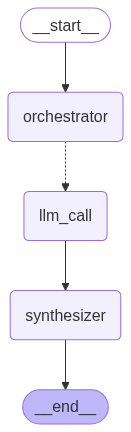

## Introduction to LLM Scaling Laws

Scaling laws represent empirical patterns that describe how the performance of Large Language Models (LLMs) changes with varying model size, dataset size, and compute resources. These mathematical relationships provide crucial insights into how model capabilities evolve as we increase their scale.

Key aspects of scaling laws include:

- **Parameter Scaling**: Performance improves predictably with model size (number of parameters) following a power-law relationship
- **Data Scaling**: Model performance improves logarithmically with training dataset size
- **Compute Scaling**: Training compute requirements grow exponentially with model improvements

Critical findings from scaling research:

- Larger models consistently outperform smaller ones when properly trained
- Performance gains from scaling are smooth and predictable
- There are currently no clear signs of diminishing returns in model scaling
- Training compute and dataset quality become increasingly important at larger scales

Practical implications:

- Enables strategic planning for AI development and resource allocation
- Helps predict required computational resources for target performance levels
- Guides decisions about model architecture and training approach
- Informs cost-benefit analysis for model development

Current scaling law limitations:

- May not capture discontinuous jumps in capabilities
- Primarily focused on next-token prediction metrics
- Less reliable for predicting emergent behaviors
- May not hold at extreme scales or with novel architectures

---

## Fundamental Scaling Laws

### Compute and Model Size Scaling
- Model loss follows a power-law relationship with compute budget: L ∝ (C/C_crit)^(-α)
- Optimal model size scales roughly with compute budget as N ∝ C^(3/4)
- Increasing compute by 8x allows doubling model parameters while maintaining training efficiency
- Diminishing returns occur but follow predictable patterns

### Dataset Scaling
- Training dataset size should scale linearly with model size
- Chinchilla scaling laws show D ∝ N, where D is dataset tokens and N is parameter count
- Under-training on too small datasets leads to poor generalization
- Over-training on limited data causes memorization and degraded performance

### Parameter Scaling
- Loss improves smoothly with increased parameter count: L ∝ N^(-α)
- Larger models show better sample efficiency and faster learning
- Architecture depth/width ratios follow empirical optimal scaling rules
- Transformer attention heads scale sub-linearly with model size

### Key Performance Relationships
- Training time scales linearly with dataset size and model parameters
- Memory requirements scale linearly with parameter count
- FLOPs per token scales quadratically with model dimension
- Validation loss provides reliable indicator of downstream task performance

### Kaplan et al. Core Findings
- Identified three key scaling laws for language models:
  1. Performance versus model size
  2. Performance versus dataset size
  3. Performance versus compute budget
- Demonstrated predictable relationships between these variables
- Established framework for optimal model training given compute constraints
- Validated power-law scaling across multiple orders of magnitude

### Practical Implications
- Enables principled model design decisions
- Allows accurate computation of required training resources
- Helps identify efficient frontier of model scaling
- Guides choices between larger models versus more training

---

## Parameters and Computation

### Model Sizing Considerations
- Number of parameters scales quadratically with model width and linearly with depth
- Memory requirements increase linearly with batch size and sequence length
- Typical parameter counts:
  - Small models: 100M-1B parameters
  - Medium models: 1B-10B parameters  
  - Large models: 10B-175B+ parameters

### Computational Requirements
- Training FLOPs scale with:
  - Number of parameters
  - Training tokens
  - Batch size
  - Number of training steps
- Memory usage dominated by:
  - Model weights
  - Optimizer states
  - Activation gradients
  - Training batch

### Cost Analysis
- Training costs primarily driven by:
  - GPU/TPU compute hours
  - Memory bandwidth utilization
  - Storage for checkpoints and datasets
- Approximate training costs:
  - 1B parameter model: $10,000-$50,000
  - 10B parameter model: $100,000-$500,000
  - 100B+ parameter model: $1M-$10M+

### Optimization Strategies
- Parameter efficient fine-tuning
- Mixed precision training
- Gradient checkpointing
- Model parallelism
- Pipeline parallelism
- Zero redundancy optimizer
- Efficient attention mechanisms

### Finding Optimal Scale
- Consider accuracy vs cost tradeoffs
- Target minimum viable model size
- Use scaling laws to predict performance
- Balance inference latency requirements
- Account for deployment constraints
- Evaluate hardware utilization efficiency

---

## Dataset Scaling

### Data Volume Requirements
- Small models (1-10B parameters): 50-100GB of high-quality text
- Medium models (10-100B parameters): 500GB-5TB of filtered text
- Large models (>100B parameters): 5TB+ of diverse, cleaned data

### Quality Considerations
- Data cleanliness impacts training efficiency and model outputs
- Key quality metrics:
  - Deduplication rate
  - Language quality scores
  - Toxicity filtering
  - Source reputation
  - Format consistency

### Size-Performance Relationship
- Generally logarithmic scaling between dataset size and model performance
- Diminishing returns after certain thresholds
- Critical factors:
  - Data diversity vs. volume
  - Domain-specificity of training data
  - Quality-quantity tradeoffs

### Optimization Strategies
- Progressive data loading based on quality tiers
- Dynamic batch sizing for different data types
- Curriculum learning approaches
- Targeted fine-tuning on high-value datasets

### Scaling Challenges
- Storage and preprocessing requirements
- Computational costs for data cleaning
- Quality control at scale
- Dataset versioning and maintenance
- Training time optimization

### Best Practices
- Regular dataset auditing
- Balanced domain representation
- Continuous data quality monitoring
- Version control for data pipeline
- Documentation of filtering criteria

---

## Performance Metrics and Scaling

Language modeling loss follows a power law scaling with model size, decreasing predictably as parameters increase. Pre-training loss improvements of 2-3x can be achieved with each 10x increase in parameters.

Downstream task performance shows three distinct scaling patterns:

- **Smooth scaling**: Gradual improvements with model size (e.g., sentiment analysis, text classification)
- **Sharp transitions**: Sudden capability jumps at specific scale thresholds (e.g., arithmetic, reasoning tasks) 
- **Plateau regions**: Diminishing returns beyond certain sizes (e.g., basic syntax, word prediction)

Key emergent capabilities appear at predictable parameter counts:

| Parameters | Emerging Capabilities |
|------------|---------------------|
| 100M-1B | Basic syntax, simple QA |
| 1B-10B | Arithmetic, basic reasoning |
| 10B-100B | Multi-step reasoning, code generation |
| 100B+ | Advanced reasoning, specialized expertise |

Task-specific scaling properties:
- Translation quality improves log-linearly until ~10B parameters
- Reasoning accuracy shows step-function improvements at scale transitions
- Few-shot learning capabilities emerge non-linearly above 10B parameters
- Coding abilities scale roughly exponentially from 1B to 100B parameters

Performance variations across architectures:
- Decoder-only models show steeper scaling curves for reasoning tasks
- Encoder-decoder models scale more efficiently for translation
- Sparse models achieve better parameter efficiency but require larger absolute scale

Resource requirements scale superlinearly:
- Training compute increases with O(n^1.6) to O(n^2)
- Memory requirements grow linearly with model size
- Inference latency increases sublinearly due to optimization

---

## Economic and Practical Implications

### Infrastructure Requirements
- Significant computational resources needed for training and inference
  - High-performance GPUs/TPUs in large quantities
  - Extensive data center capacity with reliable power
  - High-bandwidth networking infrastructure
  - Robust storage systems for training data and model weights

### Cost Considerations
- Training expenses
  - Computing costs: $1-10M+ for large model training runs
  - Energy consumption: 100s-1000s MWh per training cycle
  - Data acquisition and preparation
  - Engineering talent and expertise
- Inference costs
  - Per-query computing expenses
  - API infrastructure maintenance
  - Model updating and fine-tuning

### Scaling Challenges
- Hardware limitations
  - Memory constraints for larger models
  - GPU/TPU availability and supply chain issues
  - Cooling requirements and thermal management
- Software optimization needs
  - Distributed training coordination
  - Load balancing and request handling
  - Version control for large model weights

### Practical Implementation Issues
- Model deployment complexity
  - Server provisioning and capacity planning
  - Latency management
  - High availability requirements
- Operational considerations
  - Model monitoring and maintenance
  - Security and access controls
  - Regulatory compliance
  - Disaster recovery planning

### ROI Factors
- Business model alignment
  - API pricing strategies
  - Computing resource allocation
  - Customer service requirements
- Performance metrics
  - Response time targets
  - Accuracy requirements
  - Uptime guarantees
- Market competition
  - Alternative solutions
  - Price sensitivity
  - Feature differentiation

### Risk Management
- Technical debt
  - Model versioning
  - Code maintenance
  - Documentation requirements
- Business continuity
  - Vendor dependencies
  - Backup systems
  - Support infrastructure
- Legal and compliance
  - Data privacy regulations
  - Industry-specific requirements
  - Liability considerations

---

## Future Directions and Limitations

### Current Scaling Limits
- Physical constraints on model size and training compute requirements
- Data availability bottlenecks for high-quality training
- Memory and bandwidth limitations of current hardware
- Energy consumption and environmental sustainability concerns

### Open Research Questions
- Optimal balance between model size, data, and compute
- Theoretical foundations for emergent capabilities
- Impact of architecture choices on scaling behavior
- Role of sparsity and mixture-of-experts in efficient scaling
- Relationship between scale and model robustness

### Alternative Scaling Approaches
- Sparse architectures and conditional computation
- Distillation and compression techniques
- Few-shot and in-context learning methods
- Modular and composition-based architectures
- Hardware-aware model design

### Potential Future Developments
- Novel architectures optimized for efficiency
- Advanced parallelization strategies
- Improved training algorithms and optimization methods
- Specialized hardware for large-scale training
- Distributed training infrastructure improvements

### Efficiency Improvements
- Better parameter utilization
- Reduced training time and compute requirements
- Lower inference costs
- Improved data efficiency
- Energy consumption optimization

### Methodological Challenges
- Reproducibility of large-scale experiments
- Standardization of scaling metrics
- Validation of scaling predictions
- Cost-benefit analysis frameworks
- Risk assessment for larger models

In [8]:
from langgraph.types import Send
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])